# Solution {-}

Given a 2-dimensional coordinate frame where the x-axis points horizontally and the y-axis points vertically. A cannon ball is fired with the speed $v$ in an angle $\theta$ realtive to the x-axis. Gravity is the only force acting on the cannon ball, i.e. air resistance can be neglected.

The dynamic equation is given as:
\begin{equation}
  \dot{x}=Fx+Gu+Bu_d
\end{equation}

, where $F$ and $G$ are matrices. The vector $Bu_d$ contains the external forces and $u$ is white noise.

The state vector is given as:
$$
x =
\begin{bmatrix}
  x\\
  \dot{x}\\
  y\\
  \dot{y}\\
\end{bmatrix}
$$

## Dynamic equation
$$
\begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
  \dot{y}\\
  \ddot{y}\\
\end{bmatrix} =
\begin{bmatrix}
  \begin{array}{cc|cc}
    0 &1 &0 &0\\
    0 &0 &0 &0\\ \hline
    0 &0 &0 &1\\
    0 &0 &0 &0\\
  \end{array}
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
  y\\
  \dot{y}\\
\end{bmatrix} +
\begin{bmatrix}
  0 &0\\
  \sqrt{q_v} &0\\
  0 &0\\
  0 &\sqrt{q_v}\\
\end{bmatrix} u +
\begin{bmatrix}
  0\\
  0\\
  0\\
  -g\\
\end{bmatrix}
$$

In [1]:
from sympy import Matrix, eye, symbols, sqrt, integrate

g, qv, dt = symbols('g qv dt')

# Dynamic matrix
F = Matrix([[0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0]])

# Control vector
L = Matrix([[0],
            [0],
            [0],
            [-g]])

# Transition matrix
phi = eye(4) + F*dt

display(phi)

Matrix([
[1, dt, 0,  0],
[0,  1, 0,  0],
[0,  0, 1, dt],
[0,  0, 0,  1]])

In [2]:
# Control vector
Lambda = integrate(phi@L, dt)

display(Lambda)

Matrix([
[         0],
[         0],
[-dt**2*g/2],
[     -dt*g]])

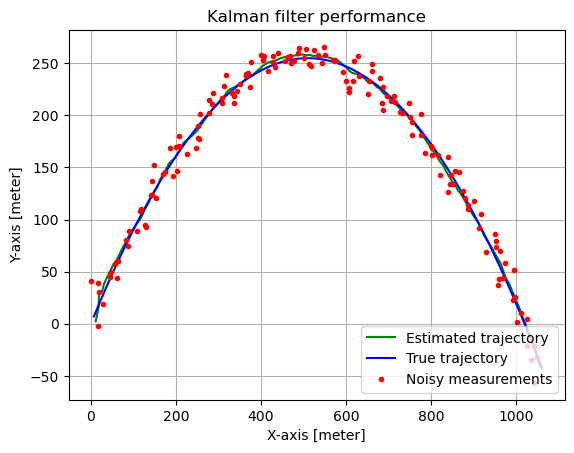

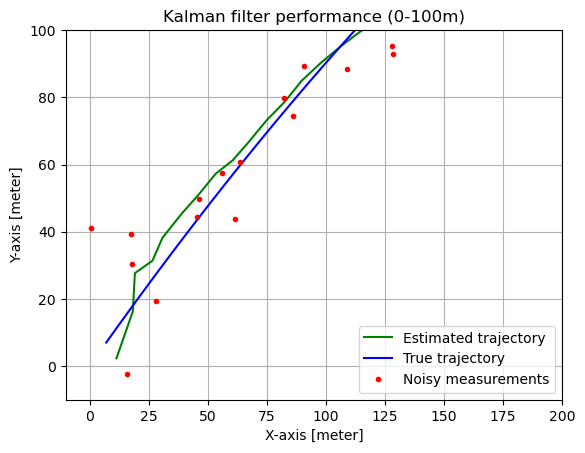

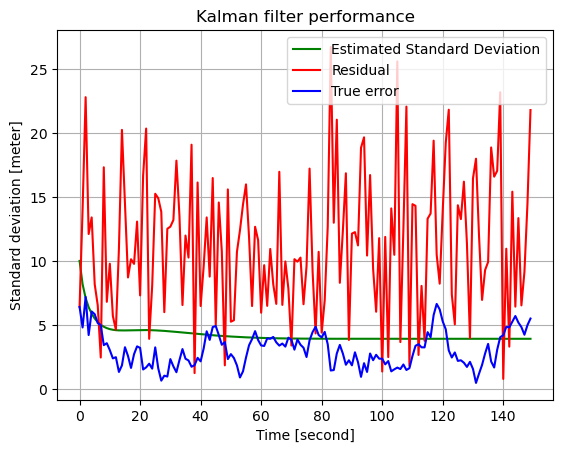

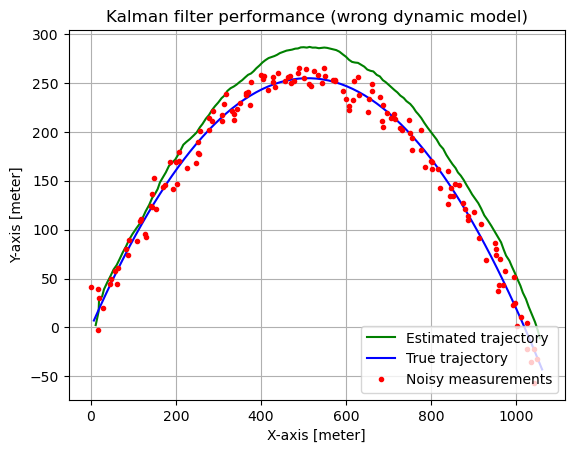

In [3]:
from numpy import array, eye, kron, pi, sin, cos, arange
from numpy.random import normal
from scipy.linalg import inv, norm
import matplotlib.pyplot as plt
from lib.vanloan import numeval

# System values
samples = 150
dt = 0.1             # [second]
theta = 45*(pi/180)  # [radian]
v = 100              # [meter/second]
g = 9.81             # [meter/second^2]

# Process values
qv = 1**2            # [meter^2/second^3]

# Measurement covariance matrix
r = 10**2            # [meter^2]
R = array([[r, 0],
           [0, r]])

# Initial state vector
x = array([[0],
           [v*cos(theta)],
           [0],
           [v*sin(theta)]])

# Initial state vector (wrong dynamic model)
x0 = x

# Initial true state vector
xt = x

# Initial state vector covariance matrix
P = kron(eye(2), [[10**2, 0],
                  [0, 3**2]])

# Design matrix
H = array([[1, 0, 0, 0],
           [0, 0, 1, 0]])

# System size
[n, e] = H.shape

# Plot vectors
x_all = []; x0_all = []; xt_all = []; P_all = []; z_all = []
res = []; err = []

# Dynamic matrix
F = array([[0, 1, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 1],
           [0, 0, 0, 0]])

# White noise coefficients
G = array([[0, 0],
           [sqrt(qv), 0],
           [0, 0],
           [0, sqrt(qv)]])

# Control vector (Gravity)
Lambda = array([[0],
                [0],
                [-1/2*g*dt**2],
                [-g*dt]])

# Van Loan
[phi, Q] = numeval(F, G, dt)

# KF main loop
for k in range(0, samples):
    
    # True process
    xt = phi@xt + Lambda
    
    # Noisy measurements
    z = H@xt + normal(0, sqrt(r), (2, 1))
    
    # Time update
    x = phi@x + Lambda; x0 = phi@x0
    P = phi@P@phi.T + Q
        
    # Measurement update
    K = P@H.T@inv(H@P@H.T + R)
    x = x + K@(z - H@x); x0 = x0 + K@(z - H@x0)
    P = (eye(e) - K@H)@P
    
    # Accumulate plot vectors
    x_all.append(x)
    x0_all.append(x0)
    xt_all.append(xt)
    P_all.append(P)
    z_all.append(z)
    
    res.append(norm(z - H@x))
    err.append(norm([xt[0] - x[0], xt[2] - x[2]]))

# Generate plot vectors
std = [sqrt(P[0, 0] + P[2, 2]) for P in P_all]

x_est = [x[0] for x in x_all]
y_est = [x[2] for x in x_all]

x_est0 = [x[0] for x in x0_all]
y_est0 = [x[2] for x in x0_all]

x_true = [xt[0] for xt in xt_all]
y_true = [xt[2] for xt in xt_all]

x_meas = [z[0] for z in z_all]
y_meas = [z[1] for z in z_all]

# Time
time = arange(0, samples)

plt.figure(1)
plt.plot(x_est, y_est, 'g', label='Estimated trajectory')
plt.plot(x_true, y_true, 'b', label='True trajectory')
plt.plot(x_meas, y_meas, 'r.', label='Noisy measurements')
plt.title('Kalman filter performance')
plt.xlabel('X-axis [meter]')
plt.ylabel('Y-axis [meter]')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(2)
plt.plot(x_est, y_est, 'g', label='Estimated trajectory')
plt.plot(x_true, y_true, 'b', label='True trajectory')
plt.plot(x_meas, y_meas, 'r.', label='Noisy measurements')
plt.title('Kalman filter performance (0-100m)')
plt.xlabel('X-axis [meter]')
plt.ylabel('Y-axis [meter]')
plt.xlim(-10, 200)
plt.ylim(-10, 100)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(3)
plt.plot(time, std, 'g', label='Estimated Standard Deviation')
plt.plot(time, res, 'r', label='Residual')
plt.plot(time, err, 'b', label='True error')
plt.title('Kalman filter performance')
plt.xlabel('Time [second]')
plt.ylabel('Standard deviation [meter]')
plt.legend(loc='upper right')
plt.grid(True, which='both')
plt.show()

plt.figure(4)
plt.plot(x_est0, y_est0, 'g', label='Estimated trajectory')
plt.plot(x_true, y_true, 'b', label='True trajectory')
plt.plot(x_meas, y_meas, 'r.', label='Noisy measurements')
plt.title('Kalman filter performance (wrong dynamic model)')
plt.xlabel('X-axis [meter]')
plt.ylabel('Y-axis [meter]')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

## Comments
Note that due to the large uncertainty represented the initial covariance of the state vector, all the trust is put on the first measurement. However, as soon as the cannonball gains more velocity and the filter reach its steady state, the trust will eventually favor the dynamic model.

When we remove gravity in the dynamic model, the kalman filter will introduce a significant lag as it eventually puts to much trust on the (wrong) dynamic model. Thus the measurements, which in fact are correct, are given to little weight and have a hard time trying to convince the filter to adapt.

One can easily see a gap between the true or measured values and the estimated values in the last figure as the measurements tries to force the filter to follow the trajectory. Thus the dynamic process is laging behind the measurements due to the missing gravity in the dynamic model.